# 对DNA RNA统计分组统计(barcode, seq)

In [ ]:
from Bio import SeqIO
import tqdm
import os
import pandas as pd
import re
from collections import Counter

data_dir="/data/home/jinyalong/data/Sev_240624"
DNA_regexp = re.compile(r"ggtgcctgaaactag([a-z]{108,128})atg([a-z]{15})ggtggttcgggcggt",re.I) # 0610
RNA_regexp = re.compile(r"GCAGAGTACAT([a-z]+)atg([a-z]{15})ggtggttcgg",re.I)
# RNA_regexp = re.compile(r"^([a-z]+)atg([a-z]{15})ggtggttcgg",re.I)

def record_rna(match, m):
    target_seq = match.group(1)
    barcode = match.group(2)
    counter = m.get(barcode,Counter())
    counter.update([target_seq])
    m[barcode]=counter
    

def gen_abundance(fn, regexp):
    m ={}
    reverse, forward = 0,0
    for i, v in enumerate(tqdm.tqdm(SeqIO.parse(fn, format="fasta"))):
#         if i>200000:
#             break
        seq = str(v.seq)
        for match in re.finditer(regexp, seq):
            forward +=1
            record_rna(match,m,d)
        seq_reverse = str(v.seq.reverse_complement())
        for match in re.finditer(regexp, seq_reverse):
            reverse +=1
            record_rna(match,m,d)
    barcodes,seqs,counts = [],[],[]
    for b,c in m.items():
        for s,n in c.items():
            barcodes.append(b)
            seqs.append(s)
            counts.append(n)
    abundance_count_df = pd.DataFrame(data={"barcode":barcodes, "rna_seq":seqs,"rna_counts":counts})
    print(len(abundance_count_df))
    base,fname = os.path.dirname(fn),os.path.basename(fn)
    name = fname[:fname.find(".")]
    print(f"found {forward} sequences forward, {reverse} reverse")
    print(f"Converting {forward+reverse} sequences to dataframe and saving")
    abundance_count_df.to_csv(os.path.join(base,name+".csv"),index=False)
    return abundance_count_df

gen_abundance(fn=f"{datadir}/DNA1.fa",DNA_regexp)
gen_abundance(fn=f"{datadir}/pl3-1-1.fa",RNA_regexp)
gen_abundance(fn=f"{datadir}/pl3-1-2.fa",RNA_regexp)

# 清洗DNA数据 【barcode对多个序列，保留10*主序列】

In [ ]:
import pandas as pd
import numpy as np
dna_df = pd.read_csv(f"{data_dir}/DNA1.csv")
dna_df.rename(columns={"dna_seq":"seq"},inplace=True)
df = pd.read_csv("./data/mutation_db_118.csv")
df["seq"]=df["seq"].apply(lambda x:x.upper())
merge_df = pd.merge(dna_df,df,on="seq")
seq_df=merge_df.groupby("seq")["plasmid_counts"].sum().reset_index()
barcode_df=merge_df.groupby("barcode")["plasmid_counts"].sum().reset_index()
seq_df=merge_df.groupby("seq")["plasmid_counts"].sum().reset_index()
barcode_df=merge_df.groupby("barcode")["plasmid_counts"].sum().reset_index()
print("Clean DNA before", seq_df.shape[0], barcode_df.shape[0], merge_df["plasmid_counts"].sum())

barcodes, seqs, counts = [],[],[]
bar1,barm, hit=0,0,0
# merge_df = merge_df[merge_df["plasmid_counts"]>=3]
for k, g in merge_df.groupby(["barcode"]):
    if g.shape[0]==1:
        bar1+=1
        barcodes.append(g.iloc[0].barcode)
        seqs.append(g.iloc[0].seq)
        counts.append(g.iloc[0].plasmid_counts)
    else:
        barm+=1
        lst = sorted(g["plasmid_counts"].values)
        gdf = g.sort_values(by=['plasmid_counts'],ascending=False)
        top1, top2 = gdf.iloc[0].plasmid_counts,gdf.iloc[1].plasmid_counts
        if top1>10*top2:
            hit += 1
            barcodes.append(gdf.iloc[0].barcode)
            seqs.append(gdf.iloc[0].seq)
            counts.append(gdf.iloc[0].plasmid_counts)
print(bar1, barm, hit)
cdf = pd.DataFrame({"barcode":barcodes,"seq":seqs,"plasmid_counts":counts})
cdf.to_csv(f"{data_dir}/DNA1_clean.csv")
seq_cdf=cdf.groupby("seq")["plasmid_counts"].sum().reset_index()
barcode_cdf=cdf.groupby("barcode")["plasmid_counts"].sum().reset_index()
print("Clean DNA After", seq_cdf.shape[0], barcode_cdf.shape[0], cdf["plasmid_counts"].sum())

# 清洗RNA数据【保留序列长度31～41】

In [5]:
import pandas as pd
import numpy as np
rna_df = pd.read_csv(f"{data_dir}/pl3-2-2.csv")
rna_df.rename(columns={"rna_seq":"seq"},inplace=True)
rna_df["length"] = rna_df["seq"].apply(len)
rna_df["blength"] = rna_df["barcode"].apply(len)
seq_df=rna_df.groupby("seq")["rna_counts"].sum().reset_index()
barcode_df=rna_df.groupby("barcode")["rna_counts"].sum().reset_index()
print("before",seq_df.shape[0], barcode_df.shape[0], rna_df["rna_counts"].sum())
rna_df = rna_df[(rna_df["length"]<=41)&(rna_df["length"]>=31)] # 主要过滤条件
seq_df=rna_df.groupby("seq")["rna_counts"].sum().reset_index()
barcode_df=rna_df.groupby("barcode")["rna_counts"].sum().reset_index()
print("after",seq_df.shape[0], barcode_df.shape[0], rna_df["rna_counts"].sum())
barcode_df.to_csv(f"{data_dir}/pl3-2-2_clean.csv")

before 46946 13296 3421808
after 13657 10157 2973412


# 合并DNA和RNA数据

In [6]:
import pandas as pd
import numpy as np
ddf = pd.read_csv(f"{data_dir}/DNA1_clean.csv")
barcode_df = pd.read_csv(f"{data_dir}/pl3-2-2_clean.csv")
ddf = pd.merge(ddf,barcode_df,on="barcode")
fdf = ddf.groupby("seq")[["rna_counts","plasmid_counts"]].sum().reset_index()
frac = fdf["plasmid_counts"].sum()/fdf["rna_counts"].sum()
fdf["abs_score"]=fdf["rna_counts"]/fdf["plasmid_counts"]*frac
fdf["score"]=np.log(fdf["abs_score"])
fdf.to_csv(f"{data_dir}/pl3-2-2_final.csv",index=False)
fdf

,seq,rna_counts,plasmid_counts,abs_score,score
0,AACCCGGGTGAGGCATCCCACCATCCTCAGTCACAGAGAGACCCAA...,39,7,1.615156,0.479432
1,AACCCGGGTGAGGCATCCCACCATTCTCCGTCACAGAGAGACCCAC...,5,36,0.040264,-3.212301
2,AACCCGGGTGAGGCATCTCCCCACCCTTAGTCACAGAGAGACCCAA...,3,2,0.434850,-0.832755
3,AACCCTGGTGAGGCATCCCACGATCTTCAGGCACAGAGAGACCCAA...,320,37,2.507242,0.919183
4,AACGCGGTTGAGGCATCCCACCATCCGCAGTCACGGAGAGACCCAA...,61,100,0.176839,-1.732516
...,...,...,...,...,...
2548,TTCCCGGGTAAGGCATCACACCATCCTCAGTCACTGAGGGACCCAA...,104,6,5.024930,1.614412
2549,TTCCCGGGTGAGGCATCCCACCACCCTCGGTCACAGATAGACCCAA...,4,11,0.105418,-2.249821
2550,TTCCCGGGTGAGGCATCCCACCATCCTCAGTCACAGAGAGACCCAA...,838,567,0.428459,-0.847561
2551,TTCCCGGGTGAGGCATCCCACCATCCTCGGTCGCAGAGAGACCCAA...,1,28,0.010354,-4.570424


In [13]:
import pandas as pd
import scipy.stats as stats
from sklearn import preprocessing

def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

datadir="/data/home/jinyalong/data/Sev_240624"
rna1 = pd.read_csv(f"{datadir}/pl3-1-2_final.csv")
rna2 = pd.read_csv(f"{datadir}/pl3-2-2_final.csv")
rna1=rna1[["seq","score"]].rename(columns={"score":"score1"})
rna2=rna2[["seq","score"]].rename(columns={"score":"score2"})
df = pd.merge(rna1,rna2,on="seq")
r = r2(df["score1"],df["score2"])
pr =  stats.pearsonr(df["score1"],df["score2"])
print('rna1, rna2 r-squared = ', r, "pearsonR = ", pr[0])

rna1, rna2 r-squared =  0.1798337246361565 pearsonR =  0.4240680660414749


(2618, 7) (138, 7)


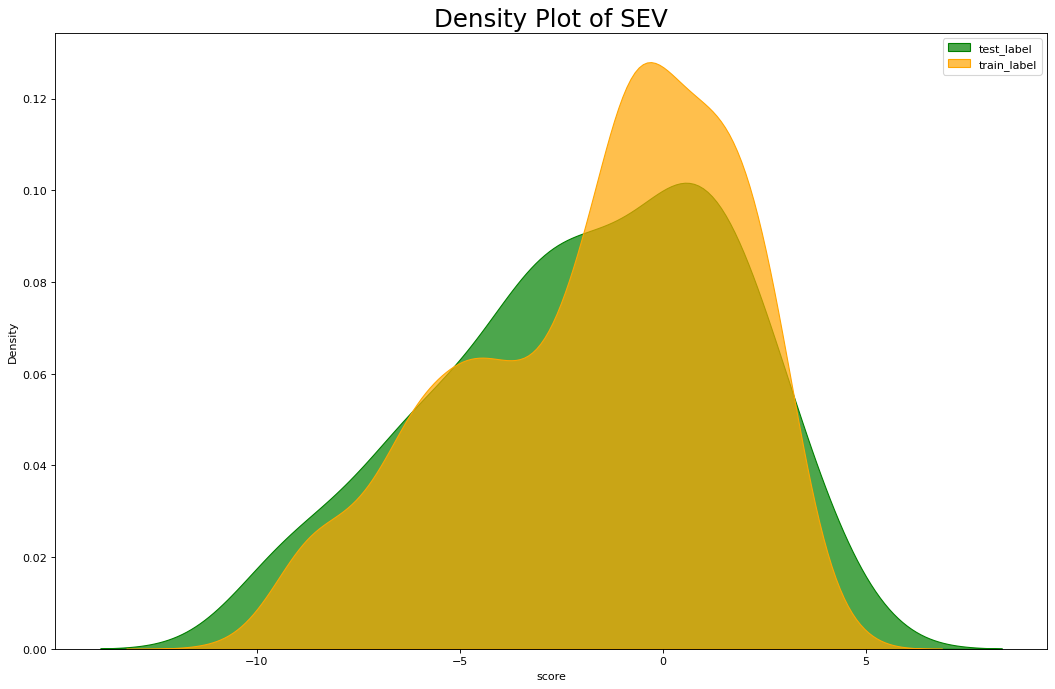

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
# 密度图
datadir="/data/home/jinyalong/data/Sev_240624"
name = "pl3-1-2"
df = pd.read_csv(f"{datadir}/{name}_final.csv")
# datadir="./data"
# df = pd.read_csv(f"{datadir}/Merge_Day5.csv")

# df["seq"] =df["dna_seq"]
df["length"] = df["seq"].apply(lambda x:len(x))
df["ttype"] = df["seq"].apply(lambda x:len(x)==118)
# df=df[(df["plasmid_counts"]>=30)&(df["rna_counts"]>=5)]
df=df[(df["plasmid_counts"]>=20)]
# df = df[(df["abs_score"]<=30)&(df["plasmid_counts"]>=20)&(df["length"]<125)&(110<=df["length"])]
split = StratifiedShuffleSplit(n_splits=1, test_size=0.05, random_state=42)
for train_idx, test_idx in split.split(df, df["length"]):
    e_train = df.iloc[train_idx].reset_index(drop=True)
    e_test = df.iloc[test_idx].reset_index(drop=True)
print(e_train.shape, e_test.shape)
# e_train = df.sample(frac=0.95)
# e_test= df[~df.index.isin(e_train.index)]
e_train.to_csv(f"{datadir}/{name}_train.csv")
e_test.to_csv(f"{datadir}/{name}_test.csv")


# Draw Plot
label = "score" # abs_score,length, score
plt.figure(figsize=(16,10), dpi= 80)
sns.kdeplot(e_test[label], shade=True, color="g", label="test_label", alpha=.7)
sns.kdeplot(e_train[label], shade=True, color="orange", label="train_label", alpha=.7) 
# sns.kdeplot(e_train['score'], shade=True, color="black", label="train_label", alpha=.7)
# sns.kdeplot(e_test['pred'], shade=True, color="dodgerblue", label="test_pred", alpha=.7)

# Decoration
plt.title('Density Plot of SEV', fontsize=22)
plt.legend()
plt.show()

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
exp,name = "sev_240222", "15-8-25-1"
# exp,name = "sev_240624", "pl3-1-1"
datadir=f"/Users/john/data/sev/{exp}/results"
df = pd.read_csv(f"{datadir}/{name}/{name}.csv")
df["length"] = df["rna_seq"].apply(lambda x:len(x))

/var/folders/g3/9kgyg0z54nv7fpxy0pgwx0y80000gn/T/ipykernel_9543/1690372607.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cdf["length"], shade=True, color="g", label="test_label", alpha=.7)


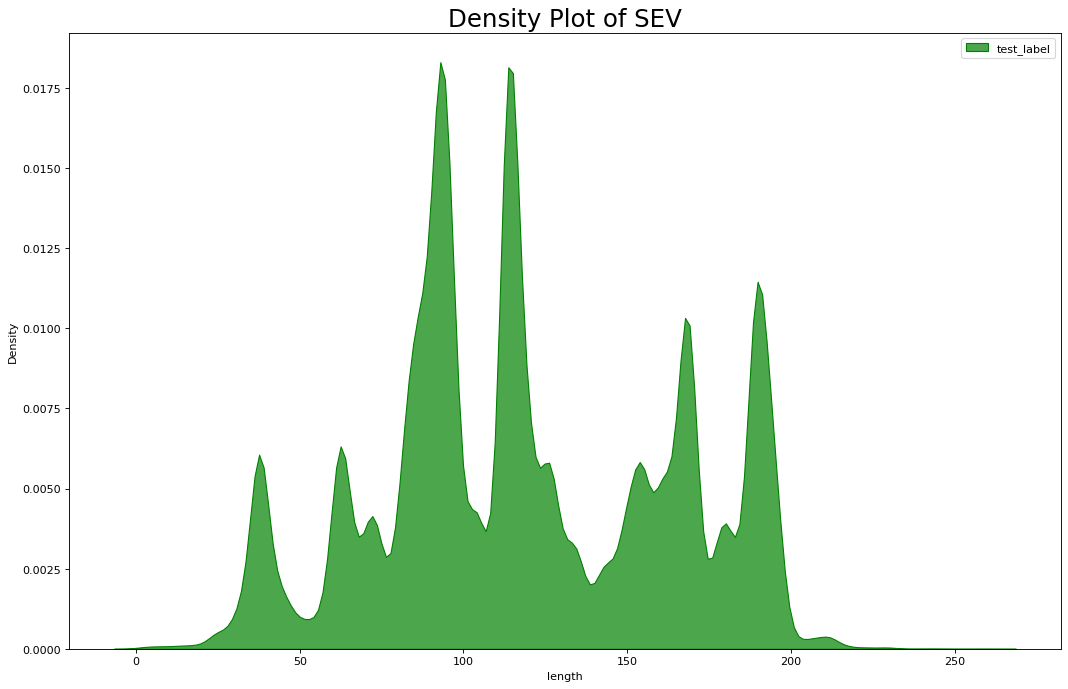

In [7]:
cdf = df
plt.figure(figsize=(16,10), dpi= 80)
sns.kdeplot(cdf["length"], shade=True, color="g", label="test_label", alpha=.7)
# sns.kdeplot(e_train['score'], shade=True, color="black", label="train_label", alpha=.7)
# sns.kdeplot(e_test['pred'], shade=True, color="dodgerblue", label="test_pred", alpha=.7)
# Decoration
plt.title('Density Plot of SEV', fontsize=22)
plt.legend()
plt.show()